# 관리자 결제 승인 시나리오 (Admin Payment Approval Scenario)

1. **결제 요청**: 사용자가 특정 금액과 목적에 대해 결제 승인을 요청
2. **워크플로우 일시정지**: `interrupt`를 통해 관리자의 응답을 기다림
3. **관리자 응답**: 승인 또는 거부 결정
4. **워크플로우 재개**: 관리자의 응답에 따라 프로세스 계속 진행

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model("openai:gpt-5-mini")
# model = init_chat_model("google_genai:gemini-2.5-flash")

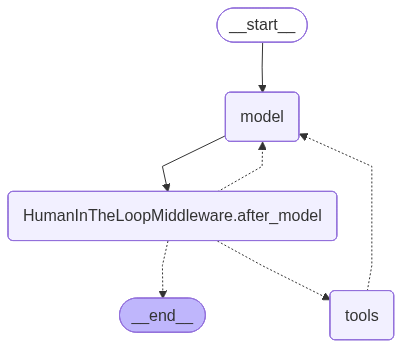

In [3]:
from uuid import uuid4
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command
from langchain.tools import tool
from langchain.messages import HumanMessage, SystemMessage

# 결제 승인 요청 도구 정의
@tool
def request_payment_approval(amount: int, purpose: str, requester: str) -> str:
    """
    관리자 결제 승인 요청 도구.

    이 도구 호출은 HumanInTheLoopMiddleware 의 정책(interrupt_on)에 의해
    모델이 바로 실행하지 않고, 먼저 사람(관리자)의 승인을 기다리게 된다.
    """
    return (
        "결제 승인 요청 발생!\n"
        f"- 요청자: {requester}\n"
        f"- 금액: {amount:,}원\n"
        f"- 목적: {purpose}\n"
        "관리자 결정을 대기 중..."
    )

# Human-in-the-Loop 미들웨어 정의
hitl = HumanInTheLoopMiddleware(
    interrupt_on={
        # 이 도구가 호출되면 무조건 인터럽트 발생
        "request_payment_approval": {
            # 이 도구에 대해 허용되는 결정 타입
            "allowed_decisions": ["approve", "reject"],
            # (선택) 이 도구 호출 시 설명 문구 커스터마이즈 가능
            "description": "결제 승인 도구 실행 전 관리자 승인이 필요합니다.",
        }
    },
    # 전역 prefix (개별 description 과 합쳐질 수 있음)
    description_prefix="Tool execution pending approval",
)

# Agent 생성
agent = create_agent(
    model=model,
    tools=[request_payment_approval],
    middleware=[hitl],
    # Human-in-the-loop 는 반드시 checkpointer 가 필요
    checkpointer=InMemorySaver()
)

agent

In [4]:
requester = "홍길동"
amount = 850_000
purpose = "세미나 출장비"

# thread_id 로 대화(실행) 스레드 구분
thread_id = f"payment-{uuid4()}"
config = {"configurable": {"thread_id": thread_id}}

# 결제 승인 요청 → HumanInTheLoopMiddleware 에 의해 interrupt 발생
response = agent.invoke(
    {
        "messages": [
            SystemMessage(
                content=(
                    "당신은 결제 승인 Human-in-the-loop 에이전트입니다. "
                    "인터럽트가 승인(approve)으로 해소되면, 대기 상태를 반복 설명하지 말고 "
                    "즉시 '승인 완료/처리 완료' 형태로만 간단히 응답하세요."
                )
            ),
            HumanMessage(
                content=(
                    f"관리자님, {requester}의 결제 요청입니다.\n"
                    f"- 금액: {amount:,}원\n- 목적: {purpose}\n"
                    "승인 여부를 판단해 주세요."
                )
            ),
        ]
    },
    config=config,
)

print("\n[1단계] 결제 요청 → 워크플로우 일시정지")
print("전체 response:", response)


[1단계] 결제 요청 → 워크플로우 일시정지
전체 response: {'messages': [SystemMessage(content="당신은 결제 승인 Human-in-the-loop 에이전트입니다. 인터럽트가 승인(approve)으로 해소되면, 대기 상태를 반복 설명하지 말고 즉시 '승인 완료/처리 완료' 형태로만 간단히 응답하세요.", additional_kwargs={}, response_metadata={}, id='0eef3621-ae62-4f8f-ab99-9c6beb0315d6'), HumanMessage(content='관리자님, 홍길동의 결제 요청입니다.\n- 금액: 850,000원\n- 목적: 세미나 출장비\n승인 여부를 판단해 주세요.', additional_kwargs={}, response_metadata={}, id='d03006fa-904a-4102-ae05-19b808140f30'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 425, 'prompt_tokens': 278, 'total_tokens': 703, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CeIE78Lf9rqFxYtT1fjeoK1DuIavU', 'service_tier': 'default'

In [5]:
# __interrupt__ 필드 안에 HITL 요청 정보가 들어 있음
interrupts = response.get("__interrupt__", [])
print("\n[interrupt 내용]")
print(interrupts)


[interrupt 내용]
[Interrupt(value={'action_requests': [{'name': 'request_payment_approval', 'args': {'amount': 850000, 'purpose': '세미나 출장비', 'requester': '홍길동'}, 'description': '결제 승인 도구 실행 전 관리자 승인이 필요합니다.'}], 'review_configs': [{'action_name': 'request_payment_approval', 'allowed_decisions': ['approve', 'reject']}]}, id='b5460bfc500a3dadd425445306e80d1a')]


In [6]:
# =========================
# 1) 관리자 결정(type 선택)
# =========================
# "approve" 또는 "reject" 중 하나를 여기서 정합니다.
decision_type = "approve"   # 또는 "reject"

# HITL 재개용 Command
admin_command = Command(
    resume={
        "decisions": [
            {
                "type": decision_type,
            }
        ]
    }
)

# HITL 재개 (approve면 도구 실행, reject면 도구 미실행 + 거절 ToolMessage 생성)
resumed = agent.invoke(admin_command, config=config)

print("\n[2단계] 워크플로우 재개 결과\n", resumed)

# =========================
# 2) 결정 타입에 따라 후속 LLM 호출 분기
# =========================
if decision_type == "approve":
    # 승인된 경우: '승인 완료/처리 완료' 형식으로 안내
    followup_prompt = (
        "결제 요청이 관리자에 의해 승인되었습니다. "
        "'승인 완료/처리 완료' 형식으로 짧게 결과만 안내해 주세요."
    )
else:
    # 거절된 경우: '결제 거절/승인 불가' 형식으로 안내
    followup_prompt = (
        "결제 요청이 관리자에 의해 거절되었습니다. "
        "'결제 거절/승인 불가' 형식으로, 간단한 사유를 포함하여 짧게 안내해 주세요."
    )

# 같은 thread_id(config)로 한 번 더 LLM 호출 → SystemMessage 규칙이 여기서 적용됨
final = agent.invoke(
    {
        "messages": [
            HumanMessage(content=followup_prompt)
        ]
    },
    config=config,
)

# 최종 안내 메시지 출력
final["messages"][-1].pretty_print()


[2단계] 워크플로우 재개 결과
 {'messages': [SystemMessage(content="당신은 결제 승인 Human-in-the-loop 에이전트입니다. 인터럽트가 승인(approve)으로 해소되면, 대기 상태를 반복 설명하지 말고 즉시 '승인 완료/처리 완료' 형태로만 간단히 응답하세요.", additional_kwargs={}, response_metadata={}, id='0eef3621-ae62-4f8f-ab99-9c6beb0315d6'), HumanMessage(content='관리자님, 홍길동의 결제 요청입니다.\n- 금액: 850,000원\n- 목적: 세미나 출장비\n승인 여부를 판단해 주세요.', additional_kwargs={}, response_metadata={}, id='d03006fa-904a-4102-ae05-19b808140f30'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 425, 'prompt_tokens': 278, 'total_tokens': 703, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CeIE78Lf9rqFxYtT1fjeoK1DuIavU', 'service_tier': 'default', 'finish_reason': 